## calculation of  order parameter 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from PyLTSpice import SimCommander, RawRead
import pandas as pd
import glob
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import os, shutil
from scipy.signal import windows
import time, re

In [46]:
np.size(np.arange(0.00001, 0.05, 0.0002))

250

In [47]:
# ==========================================================
# CONFIG
# ==========================================================

#K_values=np.arange(0.0001, 0.05, 0.0002)
#inter_R_values = np.logspace(np.log10(100), np.log10(3000), 50) #np.linspace(5,3000, 50)
inter_R_values = np.logspace(np.log10(100), np.log10(5000), 50) #np.linspace(5,3000, 50)





# ==========================================================
# PHASE 2 — BUILD RAW FILE MAPPING
# ==========================================================
all_raw_files = glob.glob("inter_R_*.raw")
raw_files = [f for f in all_raw_files if ".op" not in f] 
raw_files =  sorted(raw_files, key=lambda x: int(re.search(r'(\d+)', x).group()))
print(f"\nDetected {len(raw_files)} .raw files in total.")

# LTspice usually names them 1.raw, 2.raw, ..., matching order of execution.
# So we can assume ascending order corresponds to increasing R.
raw_mapping = list(zip(inter_R_values[:len(raw_files)], raw_files))


Detected 50 .raw files in total.


In [48]:
def compute_order_parameter(raw, node_list):
    t = raw.get_trace("time").get_wave()
    voltages = []
    for node in node_list:
        try:
            v = raw.get_trace(node).get_wave()
            voltages.append(v)
        except KeyError:
            print(f"Warning: node {node} not found in {raw.filename}")
    if len(voltages) == 0:
        return np.nan
    voltages = np.array(voltages)

    # Compute analytic signal and instantaneous phase
    analytic = hilbert(voltages, axis=1)
    phases = np.unwrap(np.angle(analytic), axis=1)

    # Kuramoto order parameter R(t)
    R_t = np.abs(np.mean(np.exp(1j * phases), axis=0))
    # Average R(t) over last 50% of samples (steady state)
    steady_idx = int(0.0 * len(R_t))
    R_mean = np.mean(R_t[steady_idx:])
    return R_mean

In [50]:
# Correct node names from your simulation
layer1_nodes = ["V(l1vout1)", "V(l1vout2)", "V(l1vout3)", "V(l1vout4)", "V(l1vout5)"]
layer2_nodes = ["V(l2vout1)", "V(l2vout2)", "V(l2vout3)", "V(l2vout4)", "V(l2vout5)"]

In [51]:
results = []

for R, rawfile in raw_mapping:
    print(f"Analyzing {os.path.basename(rawfile)} (R={R:.2f})")
    raw = RawRead(rawfile)

    # Order parameters
    R1 = compute_order_parameter(raw, layer1_nodes)
    R2 = compute_order_parameter(raw, layer2_nodes)


    results.append((R, 1/R, R1, R2))

df = pd.DataFrame(results, columns=["Resistor","coupling", "R1", "R2"]).dropna().sort_values("Resistor")


Analyzing inter_R_100.raw (R=100.00)
Analyzing inter_R_108.raw (R=108.31)
Analyzing inter_R_117.raw (R=117.31)
Analyzing inter_R_127.raw (R=127.06)
Analyzing inter_R_138.raw (R=137.62)
Analyzing inter_R_149.raw (R=149.06)
Analyzing inter_R_161.raw (R=161.45)
Analyzing inter_R_175.raw (R=174.87)
Analyzing inter_R_189.raw (R=189.40)
Analyzing inter_R_205.raw (R=205.14)
Analyzing inter_R_222.raw (R=222.19)
Analyzing inter_R_241.raw (R=240.66)
Analyzing inter_R_261.raw (R=260.66)
Analyzing inter_R_282.raw (R=282.32)
Analyzing inter_R_306.raw (R=305.79)
Analyzing inter_R_331.raw (R=331.20)
Analyzing inter_R_359.raw (R=358.73)
Analyzing inter_R_389.raw (R=388.54)
Analyzing inter_R_421.raw (R=420.83)
Analyzing inter_R_456.raw (R=455.81)
Analyzing inter_R_494.raw (R=493.69)
Analyzing inter_R_535.raw (R=534.72)
Analyzing inter_R_579.raw (R=579.17)
Analyzing inter_R_627.raw (R=627.30)
Analyzing inter_R_679.raw (R=679.44)
Analyzing inter_R_736.raw (R=735.90)
Analyzing inter_R_797.raw (R=797.07)
A

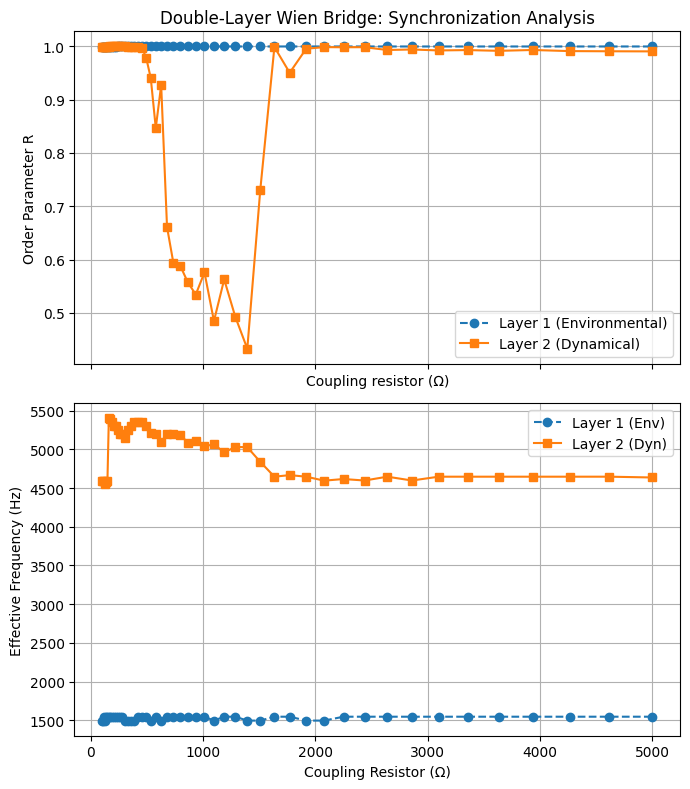

In [52]:

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# --- (a) Order parameters
axes[0].plot(df["Resistor"], df["R1"], "o--", label="Layer 1 (Environmental)")
axes[0].plot(df["Resistor"], df["R2"], "s-", label="Layer 2 (Dynamical)")
axes[0].set_ylabel("Order Parameter R")
axes[0].set_title("Double-Layer Wien Bridge: Synchronization Analysis")
axes[0].set_xlabel("Coupling resistor (Ω)")
#plt.xscale("log")
axes[0].grid(True)
axes[0].legend()


plt.tight_layout()
plt.show()

In [53]:
df2 = df.dropna().sort_values("coupling")

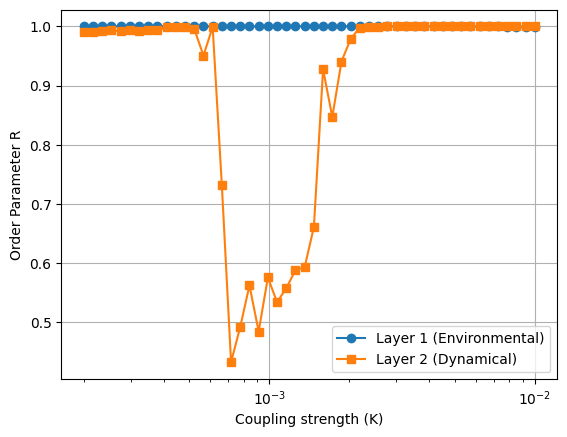

In [54]:
# --- (a) Order parameters
plt.plot(df2["coupling"], df2["R1"], "o-", label="Layer 1 (Environmental)")
plt.plot(df2["coupling"], df2["R2"], "s-", label="Layer 2 (Dynamical)")
plt.ylabel("Order Parameter R")
#axes[1].set_title("Double-Layer Wien Bridge: Synchronization Analysis")
plt.xlabel("Coupling strength (K)")
plt.grid(True)
plt.legend()
plt.xscale("log") 
#plt.xlim([0.0005,0.004])

In [11]:
df.to_csv("results_backward.csv", index=False)